# $^{210}$Ra衰变

## 将数据填入map中

将粒子分为两类，带有MWPC能量的为入射重离子`mapHeavy`，不带有MWPC能量的为衰变的$\alpha$粒子`mapDecay`。

```c++
int fillMap(TTree *tree) {
	mapHeavy.clear();
	mapDecay.clear();

	pInfo pi;
	printf("filling maps   0%%");
	fflush(stdout);
	Long64_t nentry = tree->GetEntries();
	Long64_t nentry100 = nentry / 100;
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		tree->GetEntry(jentry);
		if (hit == 2) continue;
		pi.Energy = ae[0];
		pi.FStrip = afStrip[0];
		pi.BStrip = abStrip[0];
		if (me[0] < 0) {
			mapDecay.insert(make_pair(at[0], pi));
		} else {
			mapHeavy.insert(make_pair(at[0], pi));
		}

		if (jentry % nentry100 == 0) {
			printf("\b\b\b\b%3lld%%", (jentry+1)/nentry100);
			fflush(stdout);
		}
	}
	printf("\b\b\b\b100%%\n");
	return 0;
}
```

## 衰变能量-时间关系

在入射重离子处开窗，寻找对应的衰变$\alpha$粒子，并用负时间谱估算本底。

```c++
int energyTime(ULong64_t tw) {
	TH2F *hdet = new TH2F("hdet", "decayEnergy vs decayTime", 400, Double_t(-tw), Double_t(tw), 300, 5e3, 8e3);
	for (auto ih = mapHeavy.begin(); ih != mapHeavy.end(); ++ih) {
		for (auto id = mapDecay.lower_bound(ih->first-tw); id != mapDecay.end(); ++id) {
			if (id->first >= ih->first+tw) break;
			Double_t dfs = abs(id->second.FStrip - ih->second.FStrip);			// delta front strip
			Double_t dbs = abs(id->second.BStrip - ih->second.BStrip);			// delta back strip
			if (dfs >= 1.0 || dbs >= 1.0) continue;
			Long64_t dt = id->first - ih->first;								// delta time
			if (id->second.Energy >= 5000 && id->second.Energy <= 8000) hdet->Fill(dt, id->second.Energy);
			// hdet->Fill(dt, id->second.Energy);
		}
	}

	hdet->Write();
	return 0;
}

```
得到的能量-时间谱为

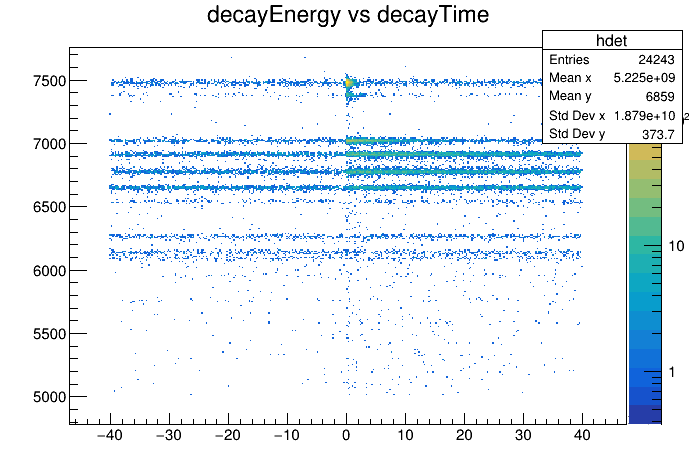

In [1]:
TFile *ipf = new TFile("../data/decay.root", "read");
TH2F *hdet = (TH2F*)ipf->Get("hdet");
TCanvas* c1 = new TCanvas;

hdet->Draw("colz");
c1->SetLogz();
c1->Draw();

## 计算衰变时间

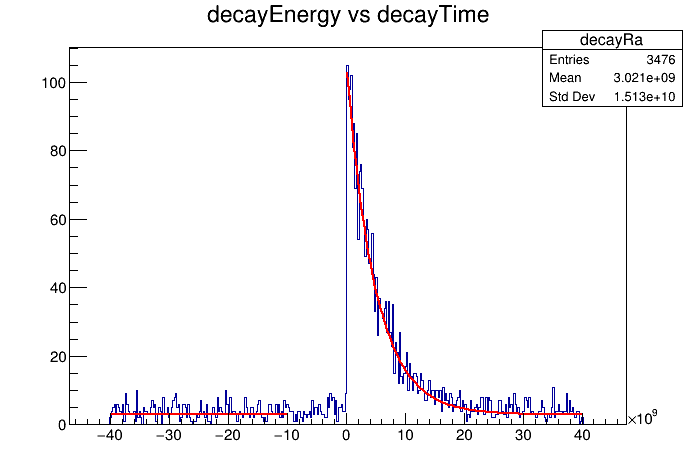

half-life time of 210Ra is 3.361073 +- 0.098061s


In [2]:
int decayTime(Double_t elow, Double_t eup, Double_t &dtime, Double_t &sdtime) {
    TH2F *hdet = (TH2F*)gDirectory->Get("hdet");
    hdet->GetYaxis()->SetRangeUser(elow, eup);
    TH1F *decayRa = (TH1F*)hdet->ProjectionX("decayRa");

    TF1 *fbkg = new TF1("fbkg", "pol0", -4e10, -1e10);
    decayRa->Fit(fbkg, "NQR+");
    Double_t p0 = fbkg->GetParameter(0);

    TF1 *fdecay = new TF1("fdecay", "[0]+[1]*exp(-x*log(2.0)/[2])", 1, 4e10);
    fdecay->FixParameter(0, p0);
    fdecay->SetParameter(2, 3e9);
    decayRa->Fit(fdecay, "NQR+");
    dtime = fdecay->GetParameter(2);
    sdtime = fdecay->GetParError(2);
    decayRa->GetListOfFunctions()->Add(fdecay);
    decayRa->GetListOfFunctions()->Add(fbkg);
    decayRa->Draw();
    //decayRa->Write();
    return 0;
}
Double_t dtime, sdtime;
decayTime(6960, 7080, dtime, sdtime);
c1->Draw();
printf("half-life time of 210Ra is %lf +- %lfs\n", dtime/1e9, sdtime/1e9);